## End member mixing analysis (EMMA) to determine streamflow source contributions

### Principal components analysis using conservative tracers using the python scikit-learn library.​

#### Here we started with solute data from Wade Brook late winter/early spring flow events captured with ISCOs. Data include:
- ICP-OES (Al, Ca, Cu, Fe, K, Mg, Mn, Na, P, Zn, Si
- IC and total elemental analyser data (Cl, SO4, NO3, PO4, TOC, DIN)
- Stable isotopes (dD, d18O)

Data are all in the Winter Watershed OneDrive directory under Documents\Link to LCBP Data (Sharepoint)/LCBP_EMMA

- For HB and WB 2023 timeseries, 17 parameters total
- For WB, 5 were found to be relatively conservative: d18O, dD, Ca, Na, Mg
- See "bivariates" notebook for those plots

The linear regression model is fitted for each conservative tracer using the first two principal components as the independent variables. The contributions are then normalized to sum to 1 for each sample. The resulting dataframe streamflow_with_contributions contains the original streamflow data along with the contributions of each endmember.

TO DO

-   [ ] adaptive naming for pca output
-   [ ] adaptive for site and tracers

In [1]:
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

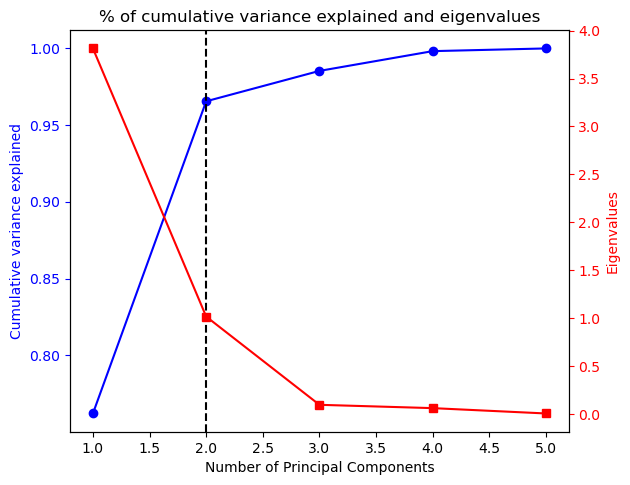

In [2]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
# See metadata joining notebook for details on combining sample index (ID) with IC, ICP and iso data
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter the data to include only the rows where 'Site' is the selected site and 'Type' is grab or ISCO (not EMs)
data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'd18O', 'dD', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Remove rows with any values that are not finite
scaled_data = scaled_data[numpy.isfinite(scaled_data).all(1)]

# Apply PCA
pca = PCA()  # Don't specify the number of components for now
pca_result = pca.fit_transform(scaled_data)

# Plot the percentage of cumulative variance explained on the primary y-axis
fig, ax1 = plt.subplots()

ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', color='blue', label='Cumulative Variance Explained')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative variance explained', color='blue')
ax1.tick_params('y', colors='blue')

# Plot a horizonal line at explain variance >80%, satifying the Christopherson & Hooper (1992) rule
ax1.axvline(x=2, color='black', linestyle='--')

# Create a second y-axis for eigenvalues
ax2 = ax1.twinx()
ax2.plot(range(1, len(pca.explained_variance_) + 1), 
         pca.explained_variance_, 
         marker='s', color='red', linestyle='-', label='Eigenvalues')
ax2.set_ylabel('Eigenvalues', color='red')
ax2.tick_params('y', colors='red')

# Plot a horizonal line at eigenvalues > 1, satifying the 'retain all ev >1 rule' (Hooper, 2003)
#ax2.axhline(y=1, color='black', linestyle='-')

# Display the legend
fig.tight_layout()
#fig.legend(loc='upper left', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.title('% of cumulative variance explained and eigenvalues')
plt.show()

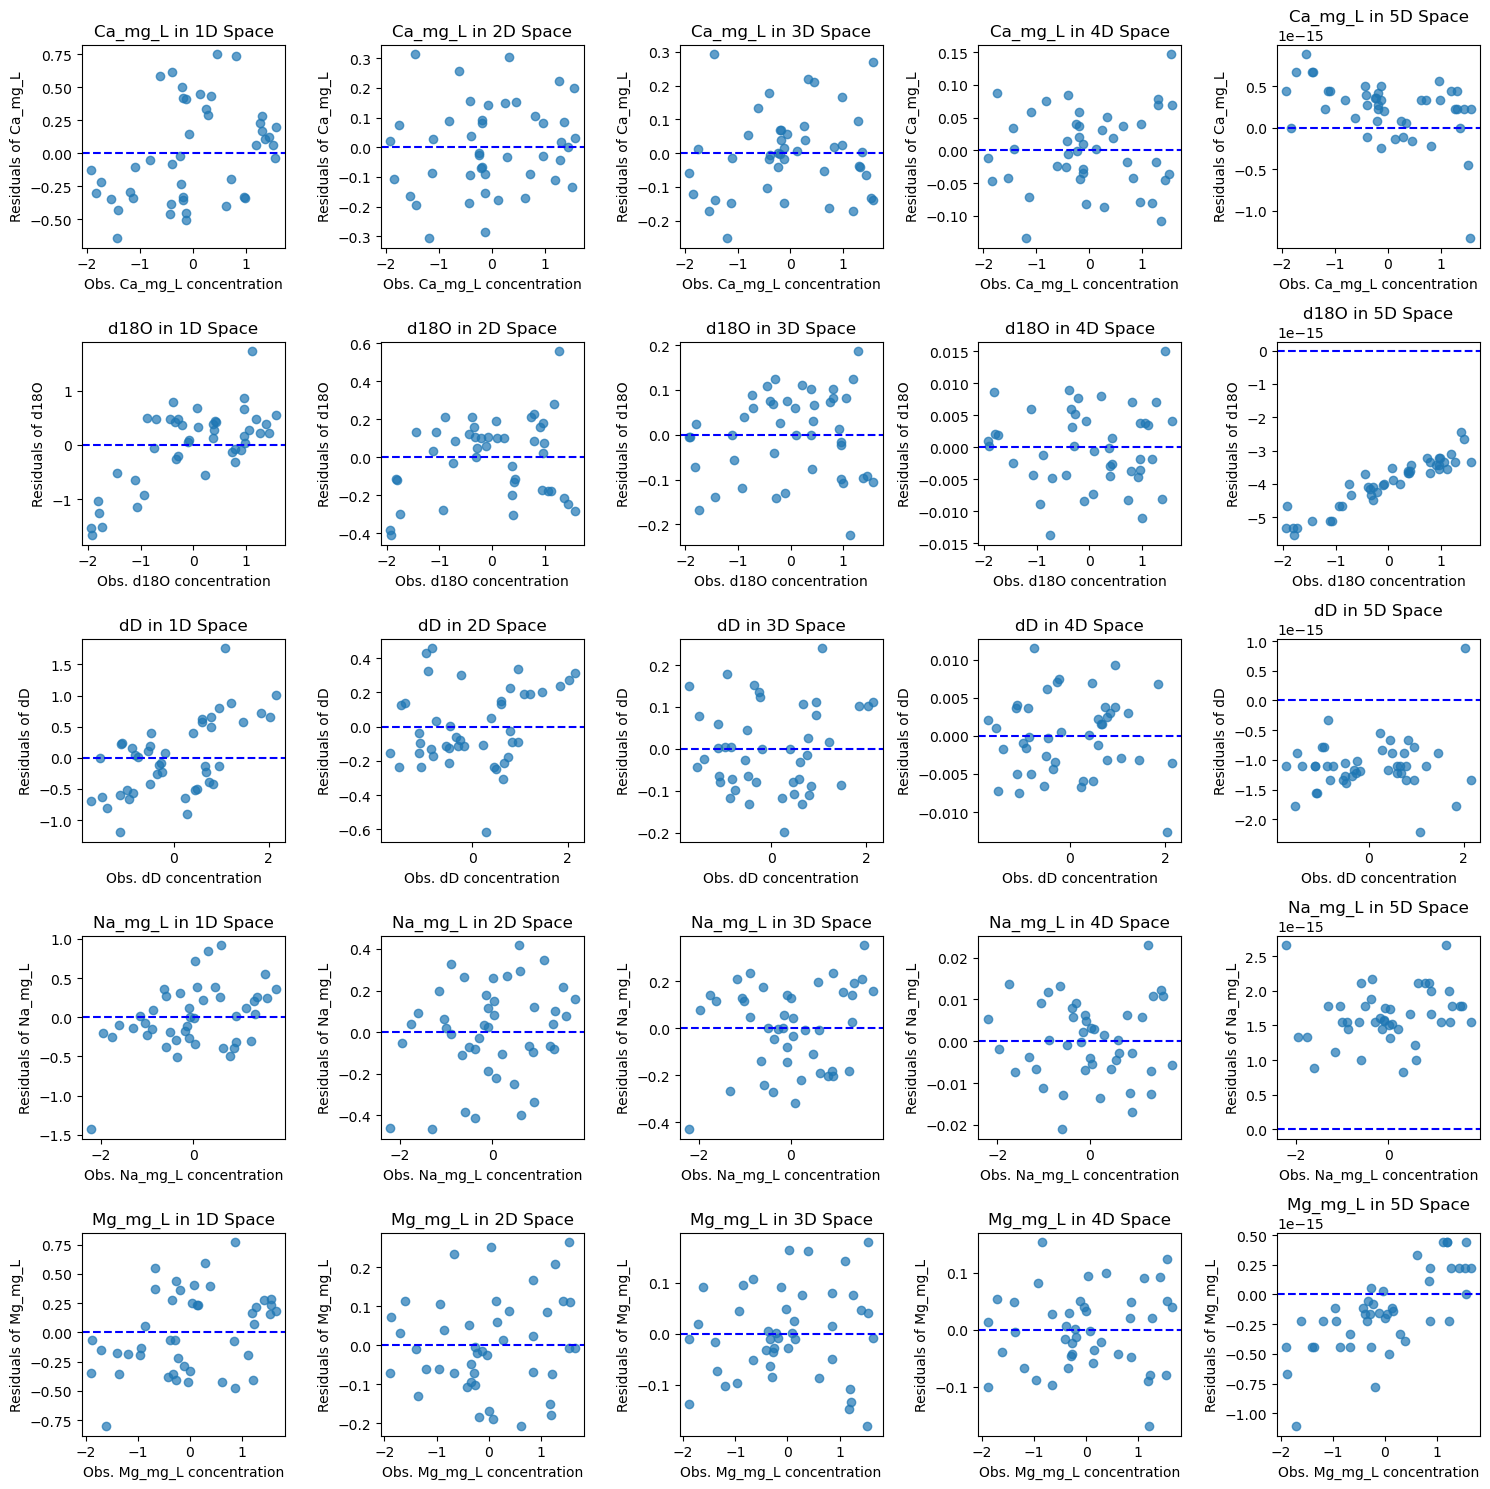

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
# See metadata joining notebook for details on combining sample index (ID) with IC, ICP and iso data
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter the data to include only the rows where 'Site' is the selected site and 'Type' is grab or ISCO (not EMs)
data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'd18O', 'dD', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# For PCA, dropping rows where there are NaN data (just for subset)
subset_data = subset_data.dropna(how='any')    #to drop if any value in the row has a nan

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Apply PCA
pca = PCA()  # Don't specify the number of components for now
pca_result = pca.fit_transform(scaled_data)

# Define the number of dimensions to consider
num_dimensions = range(1, len(selected_parameters) + 1)

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

# Plot residuals for each tracer in different mixing spaces
for i, tracer in enumerate(selected_parameters):
    for j, dim in enumerate(num_dimensions):
        # Project data onto the selected dimensions
        pca_result_subset = pca_result[:, :dim]
        
        # Reconstruct the standardized data from the selected dimensions
        reconstructed_data = np.dot(pca_result_subset, pca.components_[:dim, :])
        
        # Calculate residuals for the tracer
        residuals = scaled_data[:, i] - reconstructed_data[:, i]
        
        # Plot residuals against observed concentrations for each tracer
        ax = axes[i, j]
        ax.scatter(scaled_data[:, i], residuals, alpha=0.7, label=f'{tracer} Residuals vs observed')
        ax.axhline(y=0, color='blue', linestyle='--', label='Residual = 0')
        ax.set_title(f'{tracer} in {dim}D Space')
        ax.set_xlabel(f'Obs. {tracer} concentration')
        ax.set_ylabel(f'Residuals of {tracer}')
        #ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Once we have a specific number of components in mind, we can modify the n_components parameter when creating the PCA object:

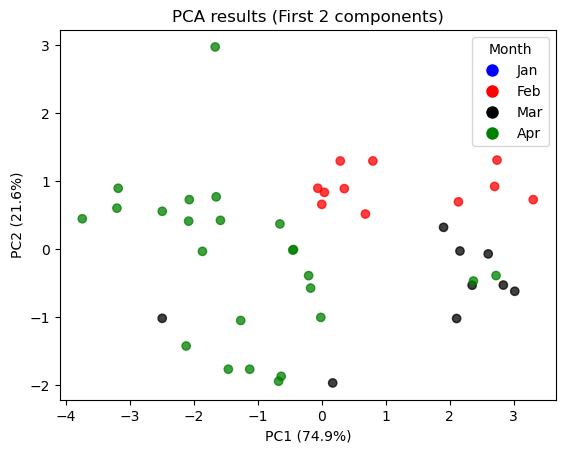

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
# See metadata joining notebook for details on combining sample index (ID) with IC, ICP and iso data
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter the data to include only the rows where 'Site' is the selected site and 'Type' is grab or ISCO (not EMs)
data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Convert the "Date" column to datetime
data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y", errors="coerce")

# For PCA, dropping rows where date is unknown *just one samples I think
#data = data.dropna(how='Date')    #to drop if any value in the row has a nan
#data = data[data['Date'].notna()]

# Select the specific parameters of interest
selected_parameters = ['Date', 'Ca_mg_L', 'd18O', 'dD', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# For PCA, dropping rows where there are NaN data (just for subset)
subset_data = subset_data.dropna(how='any')    #to drop if any value in the row has a nan

# Add a column for the event based on the month
subset_data['Event'] = 'Unknown'
subset_data.loc[(subset_data['Date'] >= '2023-01-01') & (subset_data['Date'] <= '2023-01-31'), 'Event'] = 'Jan'
subset_data.loc[(subset_data['Date'] >= '2023-02-01') & (subset_data['Date'] <= '2023-02-28'), 'Event'] = 'Feb'
subset_data.loc[(subset_data['Date'] >= '2023-03-01') & (subset_data['Date'] <= '2023-03-31'), 'Event'] = 'Mar'
subset_data.loc[(subset_data['Date'] >= '2023-04-01') & (subset_data['Date'] <= '2023-04-30'), 'Event'] = 'Apr'

subset_data_nodate = subset_data.drop(['Date','Event'], axis=1) #don't want for PCA

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data_nodate)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_result = pca.fit_transform(scaled_data)

# Define colors for each event
event_colors = {'Jan': 'blue', 'Feb': 'red', \
                'Mar': 'black', 'Apr': 'green'}

# Plot the PCA results with color-coded events
colors = subset_data['Event'].map(event_colors)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.75)
plt.title('PCA results (First 2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

explained = pca.explained_variance_ratio_ * 100
plt.xlabel(f'PC1 ({explained[0]:.1f}%)')
plt.ylabel(f'PC2 ({explained[1]:.1f}%)')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=event,
                      markerfacecolor=color, markersize=10)
           for event, color in event_colors.items()]
plt.legend(handles=handles, title='Month')

plt.show()

## Now we'll add the (scaled) candidate endmembers to the PC1 vs PC2 space plot:

/tmp/ipykernel_164027/2426339593.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")
/tmp/ipykernel_164027/2426339593.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y")


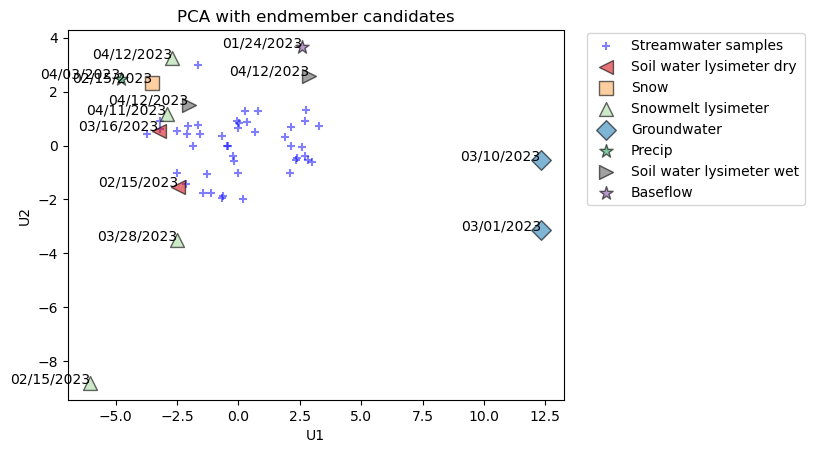

In [5]:
####################
# Import libraries #
####################

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the data from the CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Convert the "Date" column to datetime
streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")

# Load the potential endmembers from the same csv
endmember_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Snow', 'Rain', 'Baseflow', 'Groundwater', \
                        'Soil water lysimeter dry', 'Soil water lysimeter wet', 'Snowmelt lysimeter',\
                       'Precip']))
]

# Convert the "Date" column to datetime in the endmember data
endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y")

###########################################
# Separate data based on month or events #
# Asign markers to endmember types       #    
###########################################

# Define date ranges and corresponding colors for streamwater data
streamwater_date_ranges = {
    "Jan": ("2023-01-01", "2023-01-31", "#d7191c"),  # Red
    "Feb": ("2023-02-01", "2023-02-28", "#fdae61"),  # Orange
    "Mar": ("2023-03-01", "2023-03-31", "#abdda4"),  # Light Green
    "Apr": ("2023-04-01", "2023-04-30", "#2b83ba")   # Blue
}

# Define colors for each event
event_colors = {'Jan': 'blue', 'Feb': 'blue', 'Mar': 'blue', 'Apr': 'blue'}

# Define markers for endmember types
endmember_markers = {'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',\
                     'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>', \
                     'Groundwater': 'D', 'Baseflow': '*'}

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'd18O', 'dD', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_streamwater = streamwater_data[selected_parameters]

# For PCA, dropping rows where there are NaN data (just for subset)
subset_streamwater = subset_streamwater.dropna(how='any')    #to drop if any value in the row has a nan

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Handle missing values in endmembers (replace with mean)
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())

# Standardize the endmember data (mean=0 and variance=1)
scaled_endmembers = scaler.transform(subset_endmembers)

#########
# PCA  #
#########

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(subset_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for an EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)
pca_2Dresult_streamwater.to_csv("output/pca_result_streamwater.csv", index=False, header=True)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#######################
# Plotting in U space #
#######################

# Plot streamwater PCA results with blue '+' markers
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], \
            marker='+', c='blue', alpha=0.5, label='Streamwater samples')

# Add a legend for streamwater samples
handles_streamwater = [plt.Line2D([0], [0], marker='+', color='w', label='Streamwater samples',
                                  markerfacecolor='blue', markersize=10)]
plt.legend(handles=handles_streamwater)

# Plot all potential endmembers with colored markers and different shapes
for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', \
                                                               '#abdda4', '#2b83ba', \
                                                              '#2ca25f', '#636363',
                                                              '#8856a7', '#d95f0e']):
    indices = endmember_data['Type'] == event_type
    plt.scatter(
        pca_result_endmembers[indices, 0], pca_result_endmembers[indices, 1],
        marker=endmember_markers[event_type], c=color, alpha=0.60,
        label=event_type, edgecolors="black", s=100
    )
    # Add text labels for each point with the date
    for idx, (x, y) in enumerate(zip(pca_result_endmembers[indices, 0], pca_result_endmembers[indices, 1])):
        date_label = endmember_data.loc[indices].iloc[idx]['Date'].strftime('%m/%d/%Y')
        plt.text(x, y, date_label, fontsize=10, ha='right', color='black')

# Add a legend for endmember types
plt.legend(title='')
plt.legend(bbox_to_anchor=(1.5, 1.01))

plt.title('PCA with endmember candidates')
plt.xlabel('U1')
plt.ylabel('U2')
plt.show()

/tmp/ipykernel_164027/2830446214.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")
/tmp/ipykernel_164027/2830446214.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y")


Percentage of points within the triangle: 40.91%


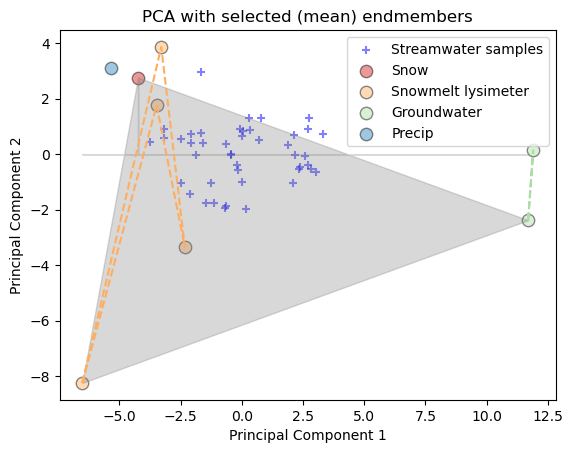

In [6]:
####################
# Import libraries #
####################

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.path import Path
import numpy as np

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the data from the CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Convert the "Date" column to datetime
streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")

# Load the potential endmembers from the same csv
endmember_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Snow', 'Rain', 'Baseflow', 'Groundwater', \
                        'Soil water lysimeter', 'Snowmelt lysimeter',\
                       'DM', 'Precip']))
]

# Convert the "Date" column to datetime in the endmember data
endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y")

###########################################
# Separate data based on month or events #
# Asign markers to endmember types       #    
###########################################

# Define date ranges and corresponding colors for streamwater data
streamwater_date_ranges = {
    "Jan": ("2023-01-01", "2023-01-31", "#d7191c"),  # Red
    "Feb": ("2023-02-01", "2023-02-28", "#fdae61"),  # Orange
    "Mar": ("2023-03-01", "2023-03-31", "#abdda4"),  # Light Green
    "Apr": ("2023-04-01", "2023-04-30", "#2b83ba")   # Blue
}

# Define colors for each event
event_colors = {'Jan': 'blue', 'Feb': 'blue', 'Mar': 'blue', 'Apr': 'blue'}

# Define markers for endmember types
endmember_markers = {'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',\
                     'Soil water lysimeter': '<', 'Groundwater': 'D', 'DM': '>', 'Baseflow': '+'}

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'd18O', 'dD', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_streamwater = streamwater_data[selected_parameters]

# For PCA, dropping rows where there are NaN data (just for subset)
subset_streamwater = subset_streamwater.dropna(how='any')    #to drop if any value in the row has a nan

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Handle missing values in endmembers (replace with mean)
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())

# Standardize the endmember data (mean=0 and variance=1)
scaled_endmembers = scaler.transform(subset_endmembers)

#########
# PCA  #
#########

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(subset_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for an EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)
pca_2Dresult_streamwater.to_csv("output/pca_result_streamwater.csv", index=False, header=True)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#######################
# Plotting in U space #
# With bounding space #
#######################

# Define vertices of the triangle formed by endmembers
triangle_vertices = pca_result_endmembers[:, :5]

# Create a Path object representing the triangle
triangle_path = Path(triangle_vertices)

# Check which points in streamwater data are within the triangle
points_within_triangle = triangle_path.contains_points(pca_result_streamwater)

# Calculate the percentage of points within the triangle
percentage_within_triangle = sum(points_within_triangle) / len(points_within_triangle) * 100

print(f"Percentage of points within the triangle: {percentage_within_triangle:.2f}%")

# Plot streamwater PCA results with blue '+' markers
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], \
            marker='+', c='blue', alpha=0.5, label='Streamwater samples')

# Explicitly define the vertices in counterclockwise order
triangle_path = Path(np.array([[triangle_vertices[0, 0], triangle_vertices[0, 1]],
                                [triangle_vertices[1, 0], triangle_vertices[1, 1]],
                                [triangle_vertices[2, 0], triangle_vertices[2, 1]],
                                [triangle_vertices[0, 0], triangle_vertices[0, 1]]]))

xs, ys = zip(*triangle_path.vertices)

# Plot all potential endmembers with colored circle markers
for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']):
    indices = endmember_data['Type'] == event_type
    plt.scatter(pca_result_endmembers[indices, 0], pca_result_endmembers[indices, 1], marker='o', c=color, \
                alpha=0.45, label=event_type, edgecolors="black", s=80)

    # Connect the endmembers with dashed lines to form a triangle
    plt.plot(pca_result_endmembers[indices, 0].tolist() + [pca_result_endmembers[indices, 0].tolist()[0]],
             pca_result_endmembers[indices, 1].tolist() + [pca_result_endmembers[indices, 1].tolist()[0]],
             linestyle='dashed', color=color)

# Add a legend for endmember types
plt.legend(title='')

# Fill the entire area below the triangle formed by the endmembers
plt.fill_between(xs, ys, color='gray', alpha=0.3)

plt.title('PCA with selected (mean) endmembers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Event-specific endmembers

### Now I want to use endmember samples that best correspond temporally with the event in question. 

### Because we retained the first two PCs, we must define the mixing space using 3 endmembers.

### There are potential endmember samples that are missing various tracer measurements. To account for this, I sometimes substitute values from similar samples, usually taken before or after. In each case, I've made a note in the endmember csv column called 'EM notes'.

#### - I also made averaged endmember when we had multiple candidate soil water lysimeter, groundwater well, or snowmelt lysimeter samples.

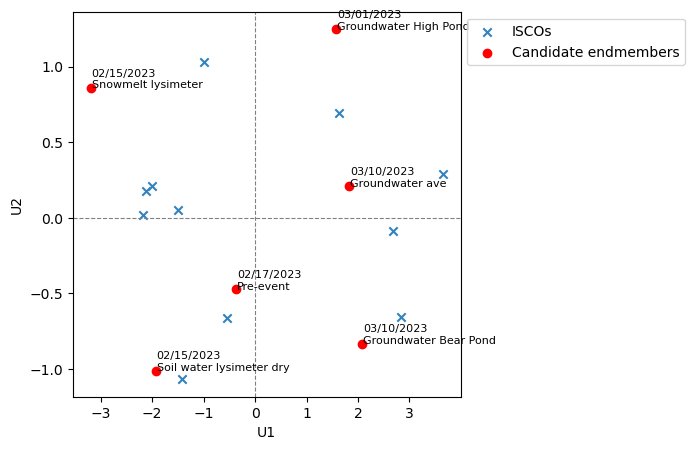

In [7]:
################
# FEB EVENT AB #
################

###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns # for residuals heatmap


###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Define the date range for the event
event_start = "2023-02-08"
event_end = "2023-02-26"

# Filter for 'Hungerford' sites, specific sample types, and the event date range
streamwater_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow'])) &
    (data['Datetime'] >= pd.to_datetime(event_start)) &
    (data['Datetime'] <= pd.to_datetime(event_end))
]

# Load the month-specific endmember data from the CSV file
em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
#em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # I only kept pre-event in these csvs for PCAs
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs

#########
# PCA  #
#########

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + selected_parameters]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=selected_parameters)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[selected_parameters]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Plot Streamwater and Endmembers in PCA Space
plt.figure(figsize=(5, 5))

# Plot streamwater samples as blue crosses
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], 
            color="#3182bd", marker='x', label="ISCOs")

# Plot endmember samples as red dots and annotate with Date and Type
plt.scatter(pca_result_endmembers[:, 0], pca_result_endmembers[:, 1], 
            color="red", marker='o', label="Candidate endmembers")

plt.xlabel("U1")
plt.ylabel("U2")
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Annotate endmember points with their Date and Type
for i, row in em_data.iterrows():
    plt.text(pca_result_endmembers[i, 0] + 0.02, pca_result_endmembers[i, 1], 
             f"{row['Date']}\n{row['Type']}", fontsize=8, color="black")


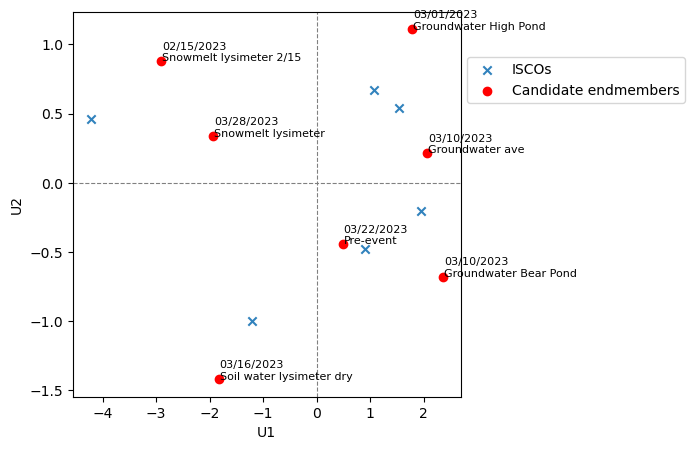

In [12]:
###############
# MAR EVENT C #
###############

###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns # for residuals heatmap


###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Define the date range for the event
event_start = "2023-03-21"
event_end = "2023-03-28"

# Filter for 'Hungerford' sites, specific sample types, and the event date range
streamwater_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow'])) &
    (data['Datetime'] >= pd.to_datetime(event_start)) &
    (data['Datetime'] <= pd.to_datetime(event_end))
]

# Load the month-specific endmember data from the CSV file
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
#em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # I only kept pre-event in these csvs for PCAs
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs

#########
# PCA  #
#########

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + selected_parameters]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=selected_parameters)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[selected_parameters]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Plot Streamwater and Endmembers in PCA Space
plt.figure(figsize=(5, 5))

# Plot streamwater samples as blue crosses
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], 
            color="#3182bd", marker='x', label="ISCOs")

# Plot endmember samples as red dots and annotate with Date and Type
plt.scatter(pca_result_endmembers[:, 0], pca_result_endmembers[:, 1], 
            color="red", marker='o', label="Candidate endmembers")

plt.xlabel("U1")
plt.ylabel("U2")
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.9))

# Annotate endmember points with their Date and Type
for i, row in em_data.iterrows():
    plt.text(pca_result_endmembers[i, 0] + 0.02, pca_result_endmembers[i, 1], 
             f"{row['Date']}\n{row['Type']}", fontsize=8, color="black")


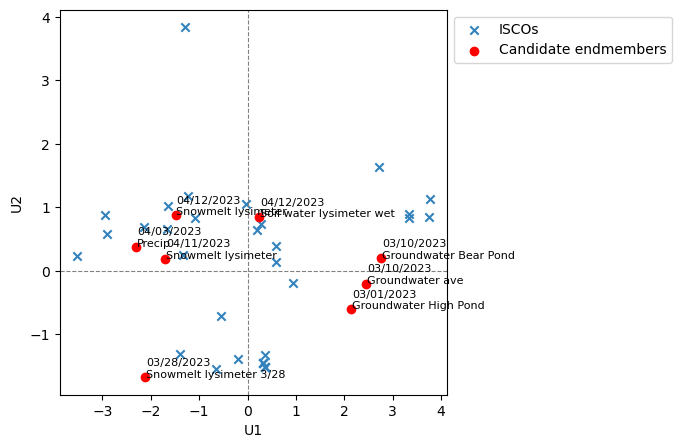

In [9]:
###############
# APR EVENT D #
###############

###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns # for residuals heatmap


###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Define the date range for the event
event_start = "2023-03-28"
event_end = "2023-04-15"

# Filter for 'Hungerford' sites, specific sample types, and the event date range
streamwater_data = data.loc[
    (data['Site'] == "Wade") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow'])) &
    (data['Datetime'] >= pd.to_datetime(event_start)) &
    (data['Datetime'] <= pd.to_datetime(event_end))
]

# Load the month-specific endmember data from the CSV file
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
#em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # I only kept pre-event in these csvs for PCAs
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs

#########
# PCA  #
#########

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + selected_parameters]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=selected_parameters)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[selected_parameters]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Plot Streamwater and Endmembers in PCA Space
plt.figure(figsize=(5, 5))

# Plot streamwater samples as blue crosses
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], 
            color="#3182bd", marker='x', label="ISCOs")

# Plot endmember samples as red dots and annotate with Date and Type
plt.scatter(pca_result_endmembers[:, 0], pca_result_endmembers[:, 1], 
            color="red", marker='o', label="Candidate endmembers")

plt.xlabel("U1")
plt.ylabel("U2")
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Annotate endmember points with their Date and Type
for i, row in em_data.iterrows():
    plt.text(pca_result_endmembers[i, 0] + 0.02, pca_result_endmembers[i, 1], 
             f"{row['Date']}\n{row['Type']}", fontsize=8, color="black")


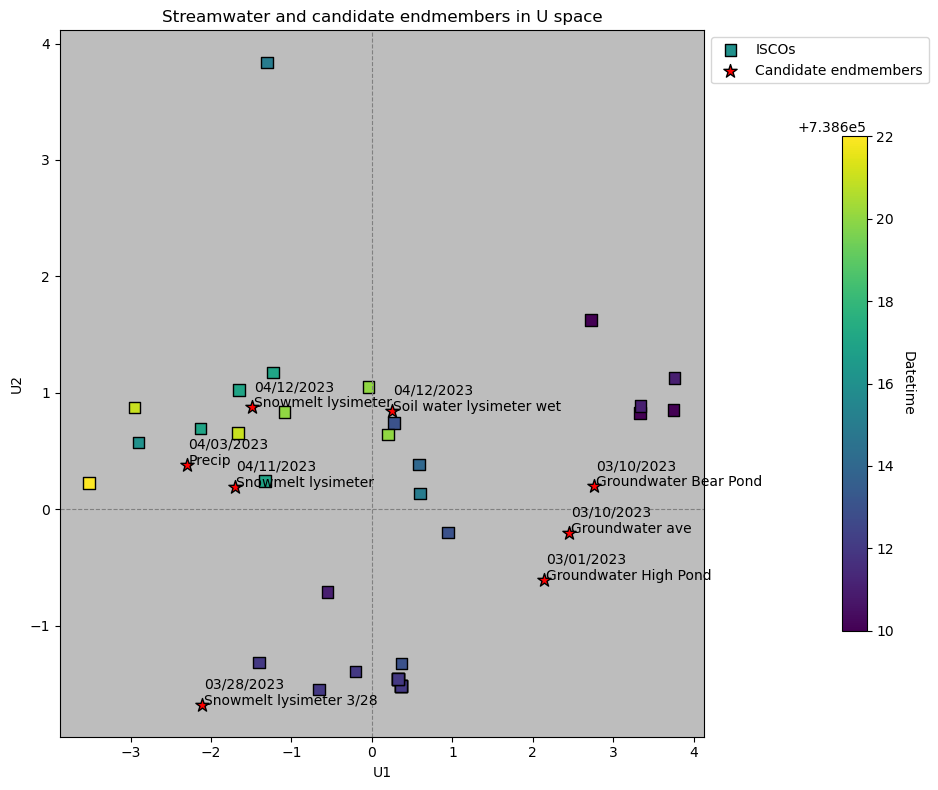

In [10]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
import seaborn as sns

# Convert Datetime to numeric for coloring
pca_2Dresult_streamwater['Datetime_numeric'] = pca_2Dresult_streamwater['Datetime'].map(lambda x: x.toordinal())

# Normalize Datetime values for colormap
norm = Normalize(vmin=pca_2Dresult_streamwater['Datetime_numeric'].min(), 
                 vmax=pca_2Dresult_streamwater['Datetime_numeric'].max())

# Create a colormap
cmap = plt.cm.viridis

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of streamwater samples
scatter = ax.scatter(pca_2Dresult_streamwater['Principal Component 1'], 
                     pca_2Dresult_streamwater['Principal Component 2'], 
                     c=pca_2Dresult_streamwater['Datetime_numeric'], 
                     cmap=cmap, marker='s', s = 70, label="ISCOs", edgecolor='black')

# Scatter plot of endmember samples
ax.scatter(pca_result_endmembers[:, 0], pca_result_endmembers[:, 1], 
           color="red", marker='*', s = 100, label="Candidate endmembers", edgecolor = 'black')

# Annotate endmember points with Date and Type
for i, row in em_data.iterrows():
    ax.text(pca_result_endmembers[i, 0] + 0.02, pca_result_endmembers[i, 1], 
            f"{row['Date']}\n{row['Type']}", fontsize=10, color="black")

# Create a colorbar explicitly linked to the scatter plot
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, pad=0.15, shrink=0.7)

# Add color to the color bar
cbar.set_label('Datetime', rotation=270, labelpad=15)

# Set color bar ticks for start and end of the range
start_date = pd.to_datetime(pca_2Dresult_streamwater['Datetime']).min().strftime('%Y-%m-%d')
end_date = pd.to_datetime(pca_2Dresult_streamwater['Datetime']).max().strftime('%Y-%m-%d')
#cbar.set_ticks([norm(pd.Timestamp(start_date).toordinal()), 
                #norm(pd.Timestamp(end_date).toordinal())])
#cbar.ax.set_yticklabels([start_date, end_date], fontsize=8)

# Final plot adjustments
ax.set_xlabel("U1")
ax.set_ylabel("U2")
ax.set_facecolor("#bdbdbd")
ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.8, linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("Streamwater and candidate endmembers in U space")
plt.tight_layout()
plt.show()

In [24]:
pca_2Dresult_streamwater

,Sample ID,Site,Type,Datetime,Principal Component 1,Principal Component 2,Datetime_numeric
0,RI23-1048,Wade,Grab/Isco,2023-04-06 12:00:00,-2.900071,0.572058,738616
1,RI23-1049,Wade,Grab/Isco,2023-04-07 00:00:00,-1.649029,1.023718,738617
2,RI23-1050,Wade,Grab/Isco,2023-04-07 06:00:00,-2.131619,0.692790,738617
3,RI23-1051,Wade,Grab/Isco,2023-04-07 12:00:00,-1.326137,0.244322,738617
4,RI23-1052,Wade,Grab/Isco,2023-04-07 17:00:00,-1.226830,1.175490,738617
5,RI23-1064,Wade,Grab/Isco,2023-03-31 08:00:00,3.746941,0.852507,738610
6,RI23-1065,Wade,Grab/Isco,2023-03-31 14:00:00,2.719431,1.627874,738610
7,RI23-1066,Wade,Grab/Isco,2023-03-31 20:00:00,3.332838,0.827695,738610
8,RI23-1067,Wade,Grab/Isco,2023-04-01 02:00:00,3.338129,0.888490,738611
9,RI23-1068,Wade,Grab/Isco,2023-04-01 08:00:00,3.761043,1.126217,738611
